### keynotes

In deep Q-learning, we use a neural network to approximate the Q-value function. The state is given as the input and the Q-value of all possible actions is generated as the output. 

<img src="./figures/03.png" alt="DataSet" title="DataSet" width="600" height="300" />




### packages

In [5]:
#########################################################################################################
#########################################################################################################
#########################################################################################################
#########################################################################################################

import os

import time

#########################################################################################################
########################################################################################################

import numpy as np

import pandas as pd 

import math

import random

#########################################################################################################
#########################################################################################################

import matplotlib

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

#########################################################################################################
#########################################################################################################

import gym

#########################################################################################################
#########################################################################################################

from collections import namedtuple, deque

#########################################################################################################
#########################################################################################################


from itertools import count

#########################################################################################################
#########################################################################################################


import torch

import torch.nn as nn

import torch.nn.functional as F

import torch.optim as optim

from torch.distributions import Normal, Categorical

from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

#########################################################################################################
#########################################################################################################

import warnings

warnings.filterwarnings('ignore')


### Q-network


<img src="./figures/04.png" alt="DataSet" title="DataSet" width="600" height="300" />



In [6]:
#########################################################################################################
#########################################################################################################
#########################################################################################################
#########################################################################################################

class Net(nn.Module):
    
    def __init__(self,state_num,action_num):
        
        super(Net, self).__init__()
        
        #########################################################################################################
        #########################################################################################################
        
        # The first fully connected layer
        
        self.fc1 = nn.Linear(state_num, 128)
        
        #########################################################################################################
        #########################################################################################################
        
        # The second fully connected layer
        
        self.fc2 = nn.Linear(128, 128)
        
        #########################################################################################################
        #########################################################################################################
        
        self.out = nn.Linear(128,action_num)

    def forward(self,x):
        
        x = self.fc1(x)
        
        x = F.relu(x)
        
        x = self.fc2(x)
        
        x = F.relu(x)
        
        action_prob = self.out(x)
        
        return action_prob

### Experience Replay

Experience Replay is the act of storing and replaying game states (the state, action, reward, next_state) that the RL algorithm is able to learn from. 

Experience Replay can be used in Off-Policy algorithms to learn in an offline fashion. 


Off-policy methods are able to update the algorithm’s parameters using saved and stored information from previously taken actions. 


Deep Q-Learning uses Experience Replay to learn in small batches in order to avoid skewing the dataset distribution of different states, actions, rewards, and next_states that the neural network will see. 

Importantly, the agent doesn’t need to train after each step. 

In our implementation, we use Experience Replay to train on every single step.


In [7]:
########################################################################################
########################################################################################
########################################################################################
########################################################################################


Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

########################################################################################
########################################################################################


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Deep Q Network algorithm



<img src="./figures/02.png" alt="DataSet" title="DataSet" width="600" height="300" />

#### Update the Q-function using the Bellman Equation

The Bellman Equation tells us how to update our Q-table after each step we take. 

To summarize this equation, the agent updates the current perceived value with the estimated optimal future reward which assumes that the agent takes the best current known action. 

In an implementation, the agent will search through all the actions for a particular state and choose the state-action pair with the highest corresponding Q-value.

\begin{equation}
y_{k} = r_{k} + \gamma \cdot Q^{'}(s_{k},\pi^{'}(s_{k},a_{k}|\delta^{Q^{'}})
\end{equation}


Then, the network is trained by the loss function that is described as

\begin{equation}
L(\delta^{Q})=\frac{1}{k}\cdot\sum_{K}(y_{k}-Q(s_{k},a_{k}|\delta^{Q}))^{2}
\end{equation}




$Q$ and $\delta^{Q}$: network for prediction

$Q^{'}$ and $\delta^{Q^{'}}$: target network


#### Choose an action using the Epsilon-Greedy Exploration Strategy

A common strategy for tackling the exploration-exploitation tradeoff is the Epsilon Greedy Exploration Strategy.

- At every time step when it’s time to choose an action, roll a dice
- If the dice has a probability less than epsilon, choose a random action
- Otherwise take the best known action at the agent’s current state






In [8]:
########################################################################################
########################################################################################
########################################################################################
########################################################################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

########################################################################################
########################################################################################


class Deep_Q_Network():
    
    def __init__(self,\
                 env,\
                 gamma=.99,\
                 capacity=10000,
                 batch_size=128,
                 lr=1e-4):
        
        super(Deep_Q_Network, self).__init__()
        
        #########################################################################################################
        #########################################################################################################
        
        # 00 environment parameters
        
        self.env=env
        
        state_num = env.observation_space.shape[0]
        
        action_num = env.action_space.n
        
        #########################################################################################################
        #########################################################################################################
        
        # 01 construct the evaluate and target network
        
        self.eval_net, self.target_net = Net(state_num,action_num).to(device), Net(state_num,action_num).to(device)
        
        self.target_net.load_state_dict(self.eval_net.state_dict())
        
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(),lr=lr)
        
        self.loss_func = nn.SmoothL1Loss()
        
        #########################################################################################################
        #########################################################################################################
        
        # 02 experience replay buffer
        
        self.capacity=capacity
        
        self.memory = ReplayMemory(capacity)
        
        self.batch_size=batch_size
        
        #########################################################################################################
        #########################################################################################################
        
        # 03 epsilon greedy strategy
        
        self.epsilon=.9
        
        self.epsilon_start = 0.9
        
        self.epsilon_end = 0.05
        
        self.epsilon_decay = 1000
        
        self.steps_done=0
        
        #########################################################################################################
        #########################################################################################################
        
        # 04 parameters
        
        self.gamma=gamma
        
        
        #########################################################################################################
        #########################################################################################################
        
        # 05 network update
        
        self.tau = 0.005
        

    def choose_action(self, state):
        
        #########################################################################################################
        #########################################################################################################
        
        # 01 update the epsilon
        
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end)*math.exp(-1. * self.steps_done/self.epsilon_decay)
        
        self.steps_done+=1
        
        #########################################################################################################
        #########################################################################################################

        # 02 choose an action: epsilon greedy policy
        
        if random.random()>=self.epsilon:
            
            with torch.no_grad():
            
                action = self.eval_net.forward(state).max(1)[1].view(1, 1)
            
        else: 
            
            action = torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)
            
        return action

    def learn(self):
        
        #########################################################################################################
        #########################################################################################################
        
        if len(self.memory) < self.batch_size:
            
            return
        
        #########################################################################################################
        #########################################################################################################
        
        # 01 randomly sample batch from memory
        
        transitions = self.memory.sample(self.batch_size)
        
        batch = Transition(*zip(*transitions))
        
        #########################################################################################################
        #########################################################################################################
        
        # Compute a mask of non-final states and concatenate the batch elements
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        state_batch = torch.cat(batch.state)
        
        action_batch = torch.cat(batch.action)
        
        reward_batch = torch.cat(batch.reward)
        
        #########################################################################################################
        #########################################################################################################

        # 02 compute loss 
        
        q_eval = self.eval_net(state_batch).gather(1, action_batch)
        
        #########################################################################################################
        #########################################################################################################
        
        q_next = torch.zeros(self.batch_size, device=device)
        
        with torch.no_grad():
            
            q_next[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        
        q_target = reward_batch + self.gamma * q_next
        
        #########################################################################################################
        #########################################################################################################
        
        loss = self.loss_func(q_eval, q_target.unsqueeze(1))
        
        #########################################################################################################
        #########################################################################################################

        self.optimizer.zero_grad()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_value_(self.eval_net.parameters(), 100)
        
        self.optimizer.step()
        
        #########################################################################################################
        #########################################################################################################
        
        # 03 update the parameters of target Q network
            
        eval_net_state_dict =  self.eval_net.state_dict()
        
        target_net_state_dict =  self.target_net.state_dict()
            
        for key in eval_net_state_dict:
            
            target_net_state_dict[key] = eval_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
            
        self.target_net.load_state_dict(target_net_state_dict)    

        
    def save(self):
        
        torch.save(self.eval_net.state_dict(), 'Deep_Q_Network.pth')
        
        print("====================================")
        
        print("DQN model has been saved...")
        
        print("====================================")
        

    def load(self):
        
        self.eval_net.load_state_dict(torch.load('Deep_Q_Network.pth'))
        
        print("====================================")
        
        print("DQN model has been loaded...")
        
        print("====================================")


### hyper-parameters

### environment

#### game

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

#### action Space
The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

#### Rewards
Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted. The threshold for rewards is 475 for v1.

#### Starting State
All observations are assigned a uniformly random value in (-0.05, 0.05)

#### Episode End

The episode ends if any one of the following occurs:

- Termination: Pole Angle is greater than ±12°

- Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)

- Truncation: Episode length is greater than 500 (200 for v0)

In [9]:
########################################################################################
########################################################################################
########################################################################################
########################################################################################


env_id = "CartPole-v1"

env = gym.make(env_id)



WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Visualization

In [10]:
#########################################################################################
#########################################################################################
#########################################################################################
#########################################################################################


def get_running_reward(reward_array: np.ndarray, window=100):
    
    """calculate the running reward, i.e. average of last `window` elements from rewards"""
    
    running_reward = np.zeros_like(reward_array)
    
    for i in range(window - 1):
        
        running_reward[i] = np.mean(reward_array[:i + 1])
        
    for i in range(window - 1, len(reward_array)):
        
        running_reward[i] = np.mean(reward_array[i - window + 1:i + 1])
        
    return running_reward

#########################################################################################
#########################################################################################
#########################################################################################
#########################################################################################

plt.style.use('seaborn-v0_8-darkgrid')

#########################################################################################
#########################################################################################

is_ipython = 'inline' in matplotlib.get_backend()

if is_ipython:
    
    from IPython import display
    
plt.ion()

#########################################################################################
#########################################################################################


font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

font_title = {'family' : 'Arial','weight' : 'normal','size': 20}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

#########################################################################################
#########################################################################################

def dynamic_plot(i_ep):
    
    #########################################################################################
    #########################################################################################
    
    plt.figure(1,figsize=(20,5))
    
    #########################################################################################
    #########################################################################################
    
    durations_t = torch.tensor(episodes_reward, dtype=torch.float)
    
    #########################################################################################
    #########################################################################################
    plt.clf()
    
    plt.title("Episodes {}, episode reward {}".format(i_ep,episodes_reward[-1]),**font_title)
        
    #########################################################################################
    #########################################################################################
    
    plt.xlabel('Episode',**font_label)
    
    plt.ylabel('Reward',**font_label)
    
    #########################################################################################
    #########################################################################################
    
    plt.plot(durations_t.numpy(),color='red')
    
    #########################################################################################
    #########################################################################################
    
    # 100 moving average
    
    if len(durations_t) >= 100:
        
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        
        means = torch.cat((torch.zeros(99), means))
        
        plt.plot(means.numpy(),color='green')
        
    #########################################################################################
    #########################################################################################

    plt.pause(0.001)
    
    if is_ipython:
        
        display.display(plt.gcf())
            
        display.clear_output(wait=True)

def final_plot(episodes_reward):
    
    #########################################################################################
    #########################################################################################

    fig, axs = plt.subplots(figsize = (20,5))
    
    #########################################################################################
    #########################################################################################

    labels = axs.get_xticklabels() + axs.get_yticklabels()

    [label.set_fontsize(20) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]
    
    #########################################################################################
    #########################################################################################
    
    xmajorLocator1   = MultipleLocator(50)

    axs.xaxis.set_major_locator(xmajorLocator1)

    axs.set_ylim([0,600])
    
    #########################################################################################
    #########################################################################################

    #########################################################################################
    #########################################################################################
    
    axs.set_xlabel('Episode',font_label)

    axs.set_ylabel('Reward',font_label)

    axs.plot(episodes_reward, linestyle='--',linewidth=2,color='red',label='reward per episode')
    
    axs.plot(get_running_reward(episodes_reward), linestyle='--',linewidth=3,color='green',label='Moving average reward')
    
    axs.legend(loc='center', bbox_to_anchor=(0.5, 1.1), prop=font_legend,ncol=3)

    plt.show()

### simulation

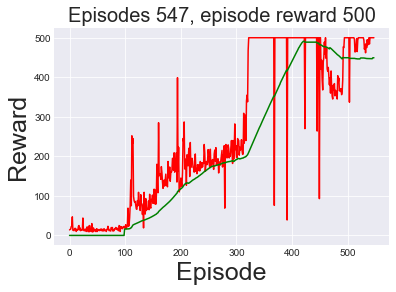

<Figure size 432x288 with 0 Axes>

In [ ]:
num_episodes = 600

agent=Deep_Q_Network(env)

episodes_reward=list()

for i_ep in range(num_episodes):
    
    ########################################################################################
    
    state = env.reset()
    
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        
        ########################################################################################
        
        action = agent.choose_action(state)
        
        ########################################################################################
        
        next_state, reward, done, _ = env.step(action.item())
        
        ########################################################################################
        
        if done:
            
            next_state = None
            
        else:
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            
        reward = torch.tensor([reward], device=device)
        
        ########################################################################################
        
        agent.memory.push(state, action, next_state, reward)
        
        ########################################################################################
        
        state = next_state
        
        ########################################################################################
    
        agent.learn()
        
        ########################################################################################
        
        #env.render()
        
        #time.sleep(1 / 30)
        
        ########################################################################################
        
        if done:
            
            episodes_reward.append(t + 1)
            
            dynamic_plot(i_ep)
            
            break
            
    
    
#     if i_ep % 10 == 0:
                
#         print("episodes {}, episode reward is {}, current epsilon is {}".format(i_ep,episodes_reward[-1],agent.epsilon))

#########################################################################################
#########################################################################################

env.close()

agent.save()

#########################################################################################
#########################################################################################


final_plot(episodes_reward)
                